# Definitions

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
data_path = Path('.', 'data')

In [3]:
RANDOM_STATE = 648

In [4]:
target_name = 'dep_delayed_15min'

# Data

In [5]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [6]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

In [8]:
train[target_name].mean()

0.19044

In [9]:
train[target_name][train.DepTime > 2400].mean()

1.0

In [10]:
train[target_name][train.DepTime > 2400].shape

(17,)

In [11]:
train.shape

(100000, 9)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [13]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [14]:
test.shape

(100000, 8)

## Split Data

In [15]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Preproc

## Exploration

<AxesSubplot:>

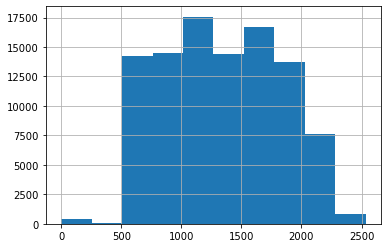

In [17]:
train.DepTime.hist()

In [18]:
train.DepTime.min(), train.DepTime.max()

(1, 2534)

In [19]:
time_groups = train.groupby((train.DepTime-1) // 100) 

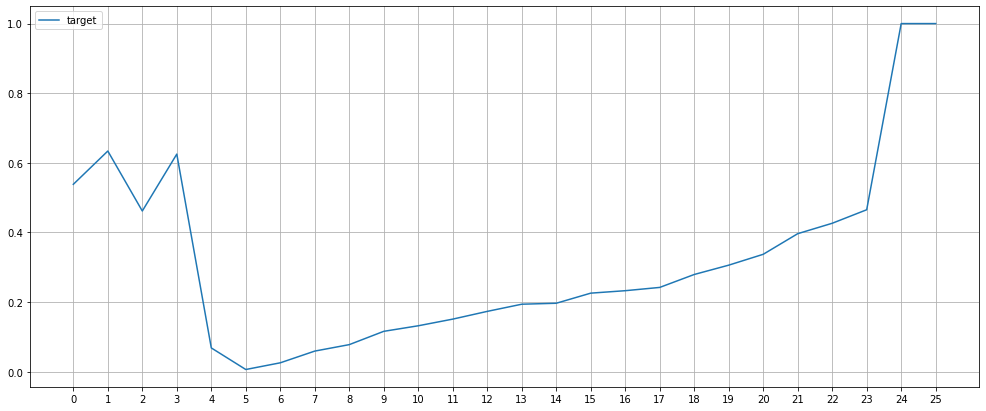

In [20]:
mean_by_t = time_groups[target_name].mean()
count_by_t = time_groups[target_name].count()

plt.figure(figsize=(17, 7))

plt.plot(mean_by_t.index, mean_by_t, label='target')
plt.xticks(range(0, 26))
plt.grid()
plt.legend()

## timestamp decoding

In [21]:
def get_ts(df):
    df['hour'] = df.DepTime // 100
    df['minute'] = df.DepTime % 100
    df['d_month'] = df.DayofMonth.str[2:].astype(int)
    df['d_week'] = df.DayOfWeek.str[2:].astype(int)
    df['month'] = df.Month.str[2:].astype(int)
    
    return df

## timestamp encoding

In [22]:
X = get_ts(X)

In [23]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,d_month,d_week,month
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,19,34,21,7,8
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,15,48,20,3,4
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,14,22,2,5,9
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,10,15,25,6,11
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,18,28,7,6,10


In [24]:
'2021-' + X.month.astype(str) + '-' + X.d_month.astype(str).str.zfill(2) + '-' + X.hour.astype(str).str.zfill(2) + '-' + X.minute.astype(str).str.zfill(2) + '-00'

0         2021-8-21-19-34-00
1         2021-4-20-15-48-00
2         2021-9-02-14-22-00
3        2021-11-25-10-15-00
4        2021-10-07-18-28-00
                ...         
99995     2021-5-04-16-18-00
99996     2021-1-18-08-04-00
99997     2021-1-24-19-01-00
99998     2021-4-27-15-15-00
99999    2021-11-17-18-00-00
Length: 100000, dtype: object

In [25]:
X_ = X[X.DepTime < 2400]
train['dep_dt'] = pd.to_datetime('2021-' + \
                             X_.month.astype(str).str.zfill(2) + '-' +
                             X_.d_month.astype(str).str.zfill(2) + '-' +
                             X_.hour.astype(str).str.zfill(2) + '-' +
                             X_.minute.astype(str).str.zfill(2) + '-00',
                             format='%Y-%m-%d-%H-%M-%S')

<AxesSubplot:>

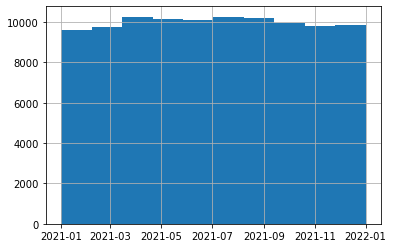

In [26]:
train.dep_dt.hist()

<AxesSubplot:xlabel='dep_dt'>

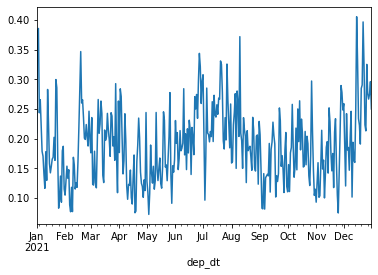

In [27]:
train.groupby(train.dep_dt.dt.to_period('d'))[target_name].mean().plot()

<AxesSubplot:xlabel='dep_dt'>

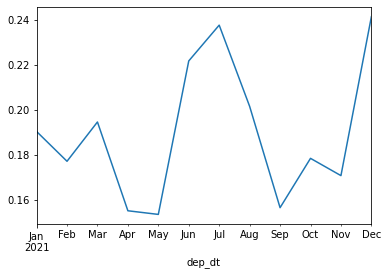

In [28]:
train.groupby(train.dep_dt.dt.to_period('M'))[target_name].mean().plot()

In [29]:
def ts_features(df):
    X_ = df[df.DepTime < 2400]
    dep_dt = pd.to_datetime('2021-' +
                                  X_.month.astype(str).str.zfill(2) + '-' +
                                  X_.d_month.astype(str).str.zfill(2) + '-' +
                                  X_.hour.astype(str).str.zfill(2) + '-' +
                                  X_.minute.astype(str).str.zfill(2) + '-00',
                                  format='%Y-%m-%d-%H-%M-%S')
    dep_td = dep_dt - pd.to_datetime('2021-01-01')
    df['days_since_ny'] = dep_td.dt.days
    df['secs_since_ny'] = dep_td.dt.seconds
    
    return df

## Category encoding

In [30]:
cat_cols = X_train.select_dtypes(include=[object, 'category']).columns

In [31]:
cat_cols

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [32]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [33]:
%%time
enc.fit(X_train[cat_cols])
print('Done')

Done
CPU times: user 134 ms, sys: 15.5 ms, total: 150 ms
Wall time: 162 ms


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Sin/cos ts processing

In [34]:
t_limits = {'minute': (0, 59),
             'hour': (0, 23),
             'd_week': (1, 7),
             'd_month': (1, 31),
             'month': (1, 12),
             'days_since_ny': (0, 364)}

In [35]:
def sin_cos(df):
    for col_name, limits in t_limits.items():
        max_val = limits[1]
        min_val = limits[0]
        if col_name == 'hour':
            orig_vals = df[col_name].clip(upper=max_val)
        else:
            orig_vals = df[col_name]
        df[col_name + '_sin'] = np.sin(2*np.pi/(max_val - min_val)*orig_vals)
        df[col_name + '_cos'] = np.cos(2*np.pi/(max_val - min_val)*orig_vals)
        
    return df

## Sum up prepocessing

In [36]:
def preproc(df):
    df = get_ts(df)
    df = ts_features(df)
    df = sin_cos(df)
    
    df[cat_cols] = enc.transform(df[cat_cols])
    df[cat_cols] = df[cat_cols].astype('category')
    
    # Special features
    df['after_midnight'] = 0
    df.loc[df.DepTime > 2400, 'after_midnight'] = 1
    
    return df

In [37]:
%%time
X_train = preproc(X_train)
X_test = preproc(X_test)

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

CPU times: user 1.41 s, sys: 110 ms, total: 1.52 s
Wall time: 1.56 s


<ipython-input-29-6ca10571684d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_since_ny'] = dep_td.dt.days
<ipython-input-29-6ca10571684d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['secs_since_ny'] = dep_td.dt.seconds
<ipython-input-35-02630819fc8c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

# Sample weights

In [38]:
def sample_weights(y):
    counts = y.value_counts()
#     exp_counts = np.exp(- counts / y.shape[0])
#     sw = exp_counts / sum(exp_counts)
    sw = y.shape[0] / (2*counts)
#     sw /= max(sw)
    return np.where(y, sw[1], sw[0])

In [39]:
pd.Series(sample_weights(y)).value_counts()

0.235239    80956
1.000000    19044
dtype: int64

# Fit

In [40]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,...,hour_cos,d_week_sin,d_week_cos,d_month_sin,d_month_cos,month_sin,month_cos,days_since_ny_sin,days_since_ny_cos,after_midnight
46343,1.0,1.0,1.0,1805,1.0,1.0,1.0,1235,18,5,...,0.203456,8.660254e-01,0.5,-9.945219e-01,-0.104528,-9.898214e-01,-0.142315,-0.770953,-0.636892,0
75701,2.0,2.0,2.0,819,2.0,2.0,2.0,892,8,19,...,-0.576680,1.224647e-16,-1.0,1.224647e-16,-1.000000,9.096320e-01,0.415415,0.700978,0.713183,0
89227,3.0,3.0,2.0,726,3.0,3.0,3.0,200,7,26,...,-0.334880,1.224647e-16,-1.0,-5.877853e-01,-0.809017,-5.406408e-01,0.841254,-0.957253,0.289252,0
70825,4.0,4.0,3.0,1515,1.0,4.0,4.0,403,15,15,...,-0.576680,8.660254e-01,0.5,8.660254e-01,-0.500000,7.557496e-01,-0.654861,0.990480,-0.137654,0
26022,5.0,5.0,4.0,1453,4.0,5.0,5.0,94,14,53,...,-0.775711,-8.660254e-01,0.5,-9.510565e-01,0.309017,-2.449294e-16,1.000000,-0.596132,0.802886,0


In [41]:
model = lgb.LGBMClassifier()

In [42]:
lgbm_params = {'boosting': 'gbdt',
               'bagging_freq': 1,
               'n_estimators': 10_000,
               'random_state': RANDOM_STATE,
               'silent': False,
               'bagging_fraction': 0.638782643397927,
               'feature_fraction': 0.5072049472753989,
               'learning_rate': 0.02238858415024258,
               'max_depth': 10,
               'min_data_in_leaf': 7,
               'reg_alpha': 4.16689412832005,
               'reg_lambda': 3.0220290348080594,
               'n_jobs': 4,
               'is_unbalance': False}

In [43]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               is_unbalance=False, learning_rate=0.02238858415024258,
               max_depth=10, min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

In [44]:
X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [45]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          sample_weight=sample_weights(y_tr),
          eval_sample_weight=[sample_weights(y_tr), sample_weights(y_es)],
          early_stopping_rounds=100)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightG

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[8]	training's auc: 0.728321	training's binary_logloss: 0.672764	valid_1's auc: 0.716541	valid_1's binary_logloss: 0.673681
[9]	training's auc: 0.729659	training's binary_logloss: 0.67045	valid_1's auc: 0.71738	valid_1's binary_logloss: 0.671532
[10]	training's auc: 0.731015	training's binary_logloss: 0.668246	valid_1's auc: 0.717434	valid_1's binary_logloss: 0.669526
[11]	training's auc: 0.73297	training's binary_logloss: 0.665954	valid_1's auc: 0.717613	valid_1's binary_logloss: 0.667528
[12]	training's auc: 0.733098	training's binary_logloss: 0.663852	valid_1's auc: 0.717786	valid_1's binary_logloss: 0.665554
[13]	training's auc: 0.734443	training's binary_logloss: 0.66177	valid_1's auc: 0.717922	valid_1's binary_logloss: 0.663792
[14]	training's auc: 0.735098	training's binary_logloss: 0.659846	valid_1's auc: 0.718399	valid_1's binary_logloss: 0.662018
[15]	training's auc: 0.73605	training's binary_logloss: 0.657913	valid_1's auc: 0.718749	valid_1's binary_logloss: 0.660306
[16]	tr

[83]	training's auc: 0.762083	training's binary_logloss: 0.597409	valid_1's auc: 0.731651	valid_1's binary_logloss: 0.612326
[84]	training's auc: 0.762461	training's binary_logloss: 0.596992	valid_1's auc: 0.731998	valid_1's binary_logloss: 0.612017
[85]	training's auc: 0.762784	training's binary_logloss: 0.59652	valid_1's auc: 0.732282	valid_1's binary_logloss: 0.611717
[86]	training's auc: 0.763323	training's binary_logloss: 0.595982	valid_1's auc: 0.732365	valid_1's binary_logloss: 0.611485
[87]	training's auc: 0.763575	training's binary_logloss: 0.595595	valid_1's auc: 0.732505	valid_1's binary_logloss: 0.611228
[88]	training's auc: 0.764085	training's binary_logloss: 0.595035	valid_1's auc: 0.732741	valid_1's binary_logloss: 0.610918
[89]	training's auc: 0.764494	training's binary_logloss: 0.59454	valid_1's auc: 0.732752	valid_1's binary_logloss: 0.610696
[90]	training's auc: 0.764705	training's binary_logloss: 0.594124	valid_1's auc: 0.732916	valid_1's binary_logloss: 0.610438
[9

[153]	training's auc: 0.780177	training's binary_logloss: 0.574518	valid_1's auc: 0.738202	valid_1's binary_logloss: 0.60133
[154]	training's auc: 0.780375	training's binary_logloss: 0.574282	valid_1's auc: 0.738242	valid_1's binary_logloss: 0.601245
[155]	training's auc: 0.780623	training's binary_logloss: 0.574013	valid_1's auc: 0.738297	valid_1's binary_logloss: 0.601182
[156]	training's auc: 0.780742	training's binary_logloss: 0.573829	valid_1's auc: 0.738433	valid_1's binary_logloss: 0.601055
[157]	training's auc: 0.78079	training's binary_logloss: 0.573629	valid_1's auc: 0.73848	valid_1's binary_logloss: 0.600921
[158]	training's auc: 0.780953	training's binary_logloss: 0.573386	valid_1's auc: 0.738523	valid_1's binary_logloss: 0.600821
[159]	training's auc: 0.781106	training's binary_logloss: 0.573194	valid_1's auc: 0.738504	valid_1's binary_logloss: 0.600773
[160]	training's auc: 0.781397	training's binary_logloss: 0.572893	valid_1's auc: 0.738502	valid_1's binary_logloss: 0.60

[220]	training's auc: 0.792239	training's binary_logloss: 0.560999	valid_1's auc: 0.741163	valid_1's binary_logloss: 0.597214
[221]	training's auc: 0.792527	training's binary_logloss: 0.56075	valid_1's auc: 0.741072	valid_1's binary_logloss: 0.597263
[222]	training's auc: 0.79274	training's binary_logloss: 0.560552	valid_1's auc: 0.741003	valid_1's binary_logloss: 0.597286
[223]	training's auc: 0.792868	training's binary_logloss: 0.56038	valid_1's auc: 0.741043	valid_1's binary_logloss: 0.597217
[224]	training's auc: 0.793076	training's binary_logloss: 0.560213	valid_1's auc: 0.740984	valid_1's binary_logloss: 0.597258
[225]	training's auc: 0.793223	training's binary_logloss: 0.560035	valid_1's auc: 0.740982	valid_1's binary_logloss: 0.597257
[226]	training's auc: 0.793417	training's binary_logloss: 0.559838	valid_1's auc: 0.741079	valid_1's binary_logloss: 0.597181
[227]	training's auc: 0.793537	training's binary_logloss: 0.559682	valid_1's auc: 0.741121	valid_1's binary_logloss: 0.59

[290]	training's auc: 0.803569	training's binary_logloss: 0.549312	valid_1's auc: 0.742461	valid_1's binary_logloss: 0.595304
[291]	training's auc: 0.803683	training's binary_logloss: 0.549186	valid_1's auc: 0.742552	valid_1's binary_logloss: 0.595223
[292]	training's auc: 0.803795	training's binary_logloss: 0.549052	valid_1's auc: 0.742557	valid_1's binary_logloss: 0.595201
[293]	training's auc: 0.803885	training's binary_logloss: 0.548934	valid_1's auc: 0.742629	valid_1's binary_logloss: 0.595146
[294]	training's auc: 0.80413	training's binary_logloss: 0.548719	valid_1's auc: 0.742579	valid_1's binary_logloss: 0.595182
[295]	training's auc: 0.804262	training's binary_logloss: 0.548587	valid_1's auc: 0.742572	valid_1's binary_logloss: 0.595161
[296]	training's auc: 0.804435	training's binary_logloss: 0.54844	valid_1's auc: 0.742627	valid_1's binary_logloss: 0.595096
[297]	training's auc: 0.804508	training's binary_logloss: 0.54833	valid_1's auc: 0.742729	valid_1's binary_logloss: 0.59

[360]	training's auc: 0.8137	training's binary_logloss: 0.539348	valid_1's auc: 0.743111	valid_1's binary_logloss: 0.594368
[361]	training's auc: 0.813879	training's binary_logloss: 0.539199	valid_1's auc: 0.743137	valid_1's binary_logloss: 0.594366
[362]	training's auc: 0.813968	training's binary_logloss: 0.539096	valid_1's auc: 0.743219	valid_1's binary_logloss: 0.594296
[363]	training's auc: 0.814047	training's binary_logloss: 0.538985	valid_1's auc: 0.743314	valid_1's binary_logloss: 0.594213
[364]	training's auc: 0.814197	training's binary_logloss: 0.538833	valid_1's auc: 0.743267	valid_1's binary_logloss: 0.594245
[365]	training's auc: 0.814301	training's binary_logloss: 0.538728	valid_1's auc: 0.743308	valid_1's binary_logloss: 0.59419
[366]	training's auc: 0.814409	training's binary_logloss: 0.538625	valid_1's auc: 0.743316	valid_1's binary_logloss: 0.594183
[367]	training's auc: 0.81463	training's binary_logloss: 0.538421	valid_1's auc: 0.743311	valid_1's binary_logloss: 0.594

[441]	training's auc: 0.823866	training's binary_logloss: 0.529392	valid_1's auc: 0.744591	valid_1's binary_logloss: 0.593377
[442]	training's auc: 0.823953	training's binary_logloss: 0.529312	valid_1's auc: 0.744602	valid_1's binary_logloss: 0.593368
[443]	training's auc: 0.824105	training's binary_logloss: 0.529171	valid_1's auc: 0.744643	valid_1's binary_logloss: 0.593359
[444]	training's auc: 0.824204	training's binary_logloss: 0.529076	valid_1's auc: 0.744637	valid_1's binary_logloss: 0.593359
[445]	training's auc: 0.824314	training's binary_logloss: 0.528966	valid_1's auc: 0.744657	valid_1's binary_logloss: 0.593349
[446]	training's auc: 0.82443	training's binary_logloss: 0.528861	valid_1's auc: 0.744666	valid_1's binary_logloss: 0.593323
[447]	training's auc: 0.824529	training's binary_logloss: 0.528769	valid_1's auc: 0.744659	valid_1's binary_logloss: 0.593338
[448]	training's auc: 0.824586	training's binary_logloss: 0.528677	valid_1's auc: 0.744663	valid_1's binary_logloss: 0.

[514]	training's auc: 0.831906	training's binary_logloss: 0.521427	valid_1's auc: 0.745213	valid_1's binary_logloss: 0.592799
[515]	training's auc: 0.831971	training's binary_logloss: 0.521351	valid_1's auc: 0.745283	valid_1's binary_logloss: 0.592758
[516]	training's auc: 0.831972	training's binary_logloss: 0.521286	valid_1's auc: 0.745299	valid_1's binary_logloss: 0.592744
[517]	training's auc: 0.832067	training's binary_logloss: 0.521179	valid_1's auc: 0.745369	valid_1's binary_logloss: 0.592695
[518]	training's auc: 0.832203	training's binary_logloss: 0.521048	valid_1's auc: 0.745369	valid_1's binary_logloss: 0.592707
[519]	training's auc: 0.832306	training's binary_logloss: 0.520941	valid_1's auc: 0.745331	valid_1's binary_logloss: 0.592746
[520]	training's auc: 0.832497	training's binary_logloss: 0.52076	valid_1's auc: 0.74527	valid_1's binary_logloss: 0.592783
[521]	training's auc: 0.832631	training's binary_logloss: 0.520649	valid_1's auc: 0.745233	valid_1's binary_logloss: 0.5

[587]	training's auc: 0.839776	training's binary_logloss: 0.51353	valid_1's auc: 0.74562	valid_1's binary_logloss: 0.592519
[588]	training's auc: 0.839874	training's binary_logloss: 0.513416	valid_1's auc: 0.74567	valid_1's binary_logloss: 0.592475
[589]	training's auc: 0.840055	training's binary_logloss: 0.513256	valid_1's auc: 0.745604	valid_1's binary_logloss: 0.592528
[590]	training's auc: 0.840158	training's binary_logloss: 0.513151	valid_1's auc: 0.745631	valid_1's binary_logloss: 0.592498
[591]	training's auc: 0.840184	training's binary_logloss: 0.513085	valid_1's auc: 0.745616	valid_1's binary_logloss: 0.592501
[592]	training's auc: 0.840265	training's binary_logloss: 0.512988	valid_1's auc: 0.7456	valid_1's binary_logloss: 0.59251
[593]	training's auc: 0.840305	training's binary_logloss: 0.512923	valid_1's auc: 0.745612	valid_1's binary_logloss: 0.592475
[594]	training's auc: 0.840478	training's binary_logloss: 0.512763	valid_1's auc: 0.745705	valid_1's binary_logloss: 0.59243

[662]	training's auc: 0.847581	training's binary_logloss: 0.505931	valid_1's auc: 0.746267	valid_1's binary_logloss: 0.592265
[663]	training's auc: 0.84768	training's binary_logloss: 0.505839	valid_1's auc: 0.746221	valid_1's binary_logloss: 0.592287
[664]	training's auc: 0.847756	training's binary_logloss: 0.50575	valid_1's auc: 0.746172	valid_1's binary_logloss: 0.59233
[665]	training's auc: 0.84786	training's binary_logloss: 0.505644	valid_1's auc: 0.746126	valid_1's binary_logloss: 0.592373
[666]	training's auc: 0.847977	training's binary_logloss: 0.505552	valid_1's auc: 0.746096	valid_1's binary_logloss: 0.592402
[667]	training's auc: 0.848035	training's binary_logloss: 0.505466	valid_1's auc: 0.746108	valid_1's binary_logloss: 0.592394
[668]	training's auc: 0.848154	training's binary_logloss: 0.505367	valid_1's auc: 0.746199	valid_1's binary_logloss: 0.592331
[669]	training's auc: 0.848252	training's binary_logloss: 0.505281	valid_1's auc: 0.746256	valid_1's binary_logloss: 0.592

[735]	training's auc: 0.854519	training's binary_logloss: 0.498861	valid_1's auc: 0.746431	valid_1's binary_logloss: 0.592367
[736]	training's auc: 0.854603	training's binary_logloss: 0.498786	valid_1's auc: 0.746344	valid_1's binary_logloss: 0.592422
[737]	training's auc: 0.854689	training's binary_logloss: 0.498697	valid_1's auc: 0.746376	valid_1's binary_logloss: 0.592409
[738]	training's auc: 0.854785	training's binary_logloss: 0.498595	valid_1's auc: 0.746436	valid_1's binary_logloss: 0.592366
[739]	training's auc: 0.854829	training's binary_logloss: 0.498535	valid_1's auc: 0.746477	valid_1's binary_logloss: 0.592329
[740]	training's auc: 0.854958	training's binary_logloss: 0.498403	valid_1's auc: 0.746496	valid_1's binary_logloss: 0.592318
[741]	training's auc: 0.855093	training's binary_logloss: 0.498287	valid_1's auc: 0.746488	valid_1's binary_logloss: 0.592337
[742]	training's auc: 0.855178	training's binary_logloss: 0.498211	valid_1's auc: 0.74643	valid_1's binary_logloss: 0.

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               is_unbalance=False, learning_rate=0.02238858415024258,
               max_depth=10, min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

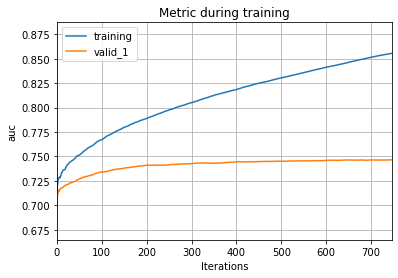

In [46]:
lgb.plot_metric(model, metric='auc')

In [47]:
fi = pd.Series(model.feature_importances_, index=X_tr.columns)

In [48]:
with pd.option_context('display.max_rows', None):
    display(fi.sort_values(ascending=False))

Origin               2997
Dest                 2954
DayofMonth           2407
UniqueCarrier        1427
Month                 999
DepTime               948
days_since_ny_sin     785
days_since_ny_cos     771
Distance              739
days_since_ny         661
secs_since_ny         556
minute_sin            505
minute_cos            466
minute                436
DayOfWeek             403
hour_sin              372
hour_cos              356
d_month               228
d_month_sin           222
d_week_sin            221
d_month_cos           187
hour                  180
d_week_cos            147
d_week                145
month_sin             123
month                  86
month_cos              59
after_midnight          0
dtype: int32

# Validate

In [49]:
def get_proba(X):
    proba = model.predict_proba(X)[:, 1]
#     proba[X.DepTime > 2400] = 1.
    return proba

In [50]:
tr_proba = get_proba(X_tr)

In [51]:
roc_auc_score(y_tr, get_proba(X_tr))

0.8456952410120253

In [52]:
roc_auc_score(y_train, get_proba(X_train))

0.8360451025912551

In [53]:
roc_auc_score(y_test, get_proba(X_test))

0.744772850559881

# Commit

## Refit on full dataset

In [54]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [55]:
enc.fit(X[cat_cols]);

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [56]:
X = preproc(X)

In [57]:
X_tr, X_es, y_tr, y_es = train_test_split(X, y,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [58]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          sample_weight=sample_weights(y_tr),
          eval_sample_weight=[sample_weights(y_tr), sample_weights(y_es)],
          early_stopping_rounds=100)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] feature_fraction is set=0.5072049472753989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5072049472753989
[LightGBM] [Warning] bagging_fraction is set=0.638782643397927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.638782643397927
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightG

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[5]	training's auc: 0.734242	training's binary_logloss: 0.681076	valid_1's auc: 0.71682	valid_1's binary_logloss: 0.682004
[6]	training's auc: 0.73249	training's binary_logloss: 0.678704	valid_1's auc: 0.71545	valid_1's binary_logloss: 0.679791
[7]	training's auc: 0.732881	training's binary_logloss: 0.676151	valid_1's auc: 0.714861	valid_1's binary_logloss: 0.677489
[8]	training's auc: 0.731528	training's binary_logloss: 0.673976	valid_1's auc: 0.71475	valid_1's binary_logloss: 0.675399
[9]	training's auc: 0.732469	training's binary_logloss: 0.671612	valid_1's auc: 0.714716	valid_1's binary_logloss: 0.673273
[10]	training's auc: 0.734669	training's binary_logloss: 0.66955	valid_1's auc: 0.715241	valid_1's binary_logloss: 0.671515
[11]	training's auc: 0.733991	training's binary_logloss: 0.667395	valid_1's auc: 0.714933	valid_1's binary_logloss: 0.669535
[12]	training's auc: 0.734108	training's binary_logloss: 0.665264	valid_1's auc: 0.715315	valid_1's binary_logloss: 0.667587
[13]	train

[80]	training's auc: 0.756388	training's binary_logloss: 0.601083	valid_1's auc: 0.728604	valid_1's binary_logloss: 0.61493
[81]	training's auc: 0.756723	training's binary_logloss: 0.600685	valid_1's auc: 0.728817	valid_1's binary_logloss: 0.614687
[82]	training's auc: 0.756934	training's binary_logloss: 0.600275	valid_1's auc: 0.729039	valid_1's binary_logloss: 0.614388
[83]	training's auc: 0.757281	training's binary_logloss: 0.599774	valid_1's auc: 0.729222	valid_1's binary_logloss: 0.614057
[84]	training's auc: 0.757637	training's binary_logloss: 0.599305	valid_1's auc: 0.729311	valid_1's binary_logloss: 0.613798
[85]	training's auc: 0.757794	training's binary_logloss: 0.598913	valid_1's auc: 0.72955	valid_1's binary_logloss: 0.613474
[86]	training's auc: 0.758125	training's binary_logloss: 0.598486	valid_1's auc: 0.729855	valid_1's binary_logloss: 0.61316
[87]	training's auc: 0.758256	training's binary_logloss: 0.598155	valid_1's auc: 0.730113	valid_1's binary_logloss: 0.612863
[88

[155]	training's auc: 0.773571	training's binary_logloss: 0.578303	valid_1's auc: 0.7379	valid_1's binary_logloss: 0.601985
[156]	training's auc: 0.773702	training's binary_logloss: 0.578114	valid_1's auc: 0.737961	valid_1's binary_logloss: 0.601912
[157]	training's auc: 0.77396	training's binary_logloss: 0.577863	valid_1's auc: 0.737936	valid_1's binary_logloss: 0.601887
[158]	training's auc: 0.774166	training's binary_logloss: 0.5776	valid_1's auc: 0.737988	valid_1's binary_logloss: 0.601774
[159]	training's auc: 0.774433	training's binary_logloss: 0.577327	valid_1's auc: 0.737972	valid_1's binary_logloss: 0.601711
[160]	training's auc: 0.774617	training's binary_logloss: 0.577102	valid_1's auc: 0.738056	valid_1's binary_logloss: 0.601608
[161]	training's auc: 0.774768	training's binary_logloss: 0.576924	valid_1's auc: 0.738205	valid_1's binary_logloss: 0.601469
[162]	training's auc: 0.774898	training's binary_logloss: 0.576765	valid_1's auc: 0.738337	valid_1's binary_logloss: 0.6013

[224]	training's auc: 0.786178	training's binary_logloss: 0.565106	valid_1's auc: 0.743128	valid_1's binary_logloss: 0.596567
[225]	training's auc: 0.786232	training's binary_logloss: 0.565003	valid_1's auc: 0.743193	valid_1's binary_logloss: 0.596487
[226]	training's auc: 0.786364	training's binary_logloss: 0.564879	valid_1's auc: 0.743255	valid_1's binary_logloss: 0.596435
[227]	training's auc: 0.786507	training's binary_logloss: 0.564757	valid_1's auc: 0.743275	valid_1's binary_logloss: 0.59642
[228]	training's auc: 0.786669	training's binary_logloss: 0.564582	valid_1's auc: 0.743393	valid_1's binary_logloss: 0.596314
[229]	training's auc: 0.786769	training's binary_logloss: 0.564457	valid_1's auc: 0.743465	valid_1's binary_logloss: 0.59624
[230]	training's auc: 0.78704	training's binary_logloss: 0.564235	valid_1's auc: 0.743534	valid_1's binary_logloss: 0.596214
[231]	training's auc: 0.787159	training's binary_logloss: 0.564106	valid_1's auc: 0.743594	valid_1's binary_logloss: 0.59

[299]	training's auc: 0.795813	training's binary_logloss: 0.554834	valid_1's auc: 0.745874	valid_1's binary_logloss: 0.593708
[300]	training's auc: 0.795976	training's binary_logloss: 0.554679	valid_1's auc: 0.745909	valid_1's binary_logloss: 0.593683
[301]	training's auc: 0.7961	training's binary_logloss: 0.554556	valid_1's auc: 0.745963	valid_1's binary_logloss: 0.593632
[302]	training's auc: 0.796205	training's binary_logloss: 0.554438	valid_1's auc: 0.745976	valid_1's binary_logloss: 0.593625
[303]	training's auc: 0.796348	training's binary_logloss: 0.554302	valid_1's auc: 0.746079	valid_1's binary_logloss: 0.593558
[304]	training's auc: 0.796455	training's binary_logloss: 0.554182	valid_1's auc: 0.746163	valid_1's binary_logloss: 0.593486
[305]	training's auc: 0.796582	training's binary_logloss: 0.554051	valid_1's auc: 0.746153	valid_1's binary_logloss: 0.593483
[306]	training's auc: 0.796734	training's binary_logloss: 0.553902	valid_1's auc: 0.746175	valid_1's binary_logloss: 0.5

[375]	training's auc: 0.804943	training's binary_logloss: 0.545714	valid_1's auc: 0.747922	valid_1's binary_logloss: 0.591737
[376]	training's auc: 0.805064	training's binary_logloss: 0.545603	valid_1's auc: 0.747923	valid_1's binary_logloss: 0.591731
[377]	training's auc: 0.805258	training's binary_logloss: 0.54544	valid_1's auc: 0.747991	valid_1's binary_logloss: 0.591716
[378]	training's auc: 0.805357	training's binary_logloss: 0.54535	valid_1's auc: 0.747991	valid_1's binary_logloss: 0.59173
[379]	training's auc: 0.805481	training's binary_logloss: 0.545243	valid_1's auc: 0.748011	valid_1's binary_logloss: 0.591732
[380]	training's auc: 0.805655	training's binary_logloss: 0.545111	valid_1's auc: 0.748069	valid_1's binary_logloss: 0.591687
[381]	training's auc: 0.805783	training's binary_logloss: 0.544995	valid_1's auc: 0.748051	valid_1's binary_logloss: 0.591692
[382]	training's auc: 0.805869	training's binary_logloss: 0.544913	valid_1's auc: 0.748069	valid_1's binary_logloss: 0.59

[444]	training's auc: 0.812324	training's binary_logloss: 0.538737	valid_1's auc: 0.74963	valid_1's binary_logloss: 0.590345
[445]	training's auc: 0.812441	training's binary_logloss: 0.538634	valid_1's auc: 0.749644	valid_1's binary_logloss: 0.590328
[446]	training's auc: 0.812536	training's binary_logloss: 0.538542	valid_1's auc: 0.749702	valid_1's binary_logloss: 0.590281
[447]	training's auc: 0.81266	training's binary_logloss: 0.538432	valid_1's auc: 0.749736	valid_1's binary_logloss: 0.590263
[448]	training's auc: 0.812734	training's binary_logloss: 0.538354	valid_1's auc: 0.749825	valid_1's binary_logloss: 0.590197
[449]	training's auc: 0.812906	training's binary_logloss: 0.538207	valid_1's auc: 0.749809	valid_1's binary_logloss: 0.590221
[450]	training's auc: 0.813012	training's binary_logloss: 0.538122	valid_1's auc: 0.749877	valid_1's binary_logloss: 0.59019
[451]	training's auc: 0.813126	training's binary_logloss: 0.538017	valid_1's auc: 0.749923	valid_1's binary_logloss: 0.59

[516]	training's auc: 0.819534	training's binary_logloss: 0.531812	valid_1's auc: 0.750241	valid_1's binary_logloss: 0.589716
[517]	training's auc: 0.819572	training's binary_logloss: 0.531754	valid_1's auc: 0.750231	valid_1's binary_logloss: 0.58973
[518]	training's auc: 0.819621	training's binary_logloss: 0.531691	valid_1's auc: 0.750239	valid_1's binary_logloss: 0.589725
[519]	training's auc: 0.819705	training's binary_logloss: 0.531604	valid_1's auc: 0.750328	valid_1's binary_logloss: 0.589665
[520]	training's auc: 0.81977	training's binary_logloss: 0.531536	valid_1's auc: 0.750387	valid_1's binary_logloss: 0.58962
[521]	training's auc: 0.819858	training's binary_logloss: 0.531436	valid_1's auc: 0.750436	valid_1's binary_logloss: 0.58959
[522]	training's auc: 0.819964	training's binary_logloss: 0.531343	valid_1's auc: 0.750472	valid_1's binary_logloss: 0.589553
[523]	training's auc: 0.820047	training's binary_logloss: 0.531246	valid_1's auc: 0.750464	valid_1's binary_logloss: 0.589

[586]	training's auc: 0.826032	training's binary_logloss: 0.525544	valid_1's auc: 0.751232	valid_1's binary_logloss: 0.589117
[587]	training's auc: 0.826116	training's binary_logloss: 0.525456	valid_1's auc: 0.751282	valid_1's binary_logloss: 0.589075
[588]	training's auc: 0.826234	training's binary_logloss: 0.525339	valid_1's auc: 0.751229	valid_1's binary_logloss: 0.589116
[589]	training's auc: 0.82631	training's binary_logloss: 0.525262	valid_1's auc: 0.751224	valid_1's binary_logloss: 0.589124
[590]	training's auc: 0.826462	training's binary_logloss: 0.525132	valid_1's auc: 0.751133	valid_1's binary_logloss: 0.589215
[591]	training's auc: 0.826607	training's binary_logloss: 0.525001	valid_1's auc: 0.751068	valid_1's binary_logloss: 0.589275
[592]	training's auc: 0.82665	training's binary_logloss: 0.524943	valid_1's auc: 0.751096	valid_1's binary_logloss: 0.589236
[593]	training's auc: 0.826705	training's binary_logloss: 0.524876	valid_1's auc: 0.751087	valid_1's binary_logloss: 0.5

[655]	training's auc: 0.831783	training's binary_logloss: 0.519877	valid_1's auc: 0.75164	valid_1's binary_logloss: 0.588852
[656]	training's auc: 0.831831	training's binary_logloss: 0.519823	valid_1's auc: 0.751701	valid_1's binary_logloss: 0.58881
[657]	training's auc: 0.831908	training's binary_logloss: 0.519742	valid_1's auc: 0.751737	valid_1's binary_logloss: 0.588786
[658]	training's auc: 0.831956	training's binary_logloss: 0.519674	valid_1's auc: 0.751734	valid_1's binary_logloss: 0.588795
[659]	training's auc: 0.832092	training's binary_logloss: 0.519573	valid_1's auc: 0.751756	valid_1's binary_logloss: 0.58878
[660]	training's auc: 0.832231	training's binary_logloss: 0.519452	valid_1's auc: 0.751737	valid_1's binary_logloss: 0.588813
[661]	training's auc: 0.832338	training's binary_logloss: 0.51936	valid_1's auc: 0.75174	valid_1's binary_logloss: 0.588822
[662]	training's auc: 0.832447	training's binary_logloss: 0.519265	valid_1's auc: 0.751639	valid_1's binary_logloss: 0.5888

[721]	training's auc: 0.837226	training's binary_logloss: 0.514593	valid_1's auc: 0.752275	valid_1's binary_logloss: 0.588526
[722]	training's auc: 0.837308	training's binary_logloss: 0.514509	valid_1's auc: 0.752299	valid_1's binary_logloss: 0.58851
[723]	training's auc: 0.837392	training's binary_logloss: 0.514448	valid_1's auc: 0.752342	valid_1's binary_logloss: 0.588467
[724]	training's auc: 0.837477	training's binary_logloss: 0.514374	valid_1's auc: 0.752322	valid_1's binary_logloss: 0.5885
[725]	training's auc: 0.83754	training's binary_logloss: 0.514302	valid_1's auc: 0.75229	valid_1's binary_logloss: 0.58851
[726]	training's auc: 0.837671	training's binary_logloss: 0.514177	valid_1's auc: 0.75225	valid_1's binary_logloss: 0.588547
[727]	training's auc: 0.83777	training's binary_logloss: 0.514083	valid_1's auc: 0.752267	valid_1's binary_logloss: 0.588522
[728]	training's auc: 0.83784	training's binary_logloss: 0.514021	valid_1's auc: 0.752272	valid_1's binary_logloss: 0.588503
[

[791]	training's auc: 0.842771	training's binary_logloss: 0.509045	valid_1's auc: 0.75313	valid_1's binary_logloss: 0.587916
[792]	training's auc: 0.842875	training's binary_logloss: 0.508961	valid_1's auc: 0.753127	valid_1's binary_logloss: 0.587932
[793]	training's auc: 0.842975	training's binary_logloss: 0.508862	valid_1's auc: 0.753105	valid_1's binary_logloss: 0.58796
[794]	training's auc: 0.843029	training's binary_logloss: 0.508804	valid_1's auc: 0.753041	valid_1's binary_logloss: 0.588009
[795]	training's auc: 0.843085	training's binary_logloss: 0.508741	valid_1's auc: 0.753069	valid_1's binary_logloss: 0.587977
[796]	training's auc: 0.843185	training's binary_logloss: 0.508653	valid_1's auc: 0.753061	valid_1's binary_logloss: 0.58799
[797]	training's auc: 0.843263	training's binary_logloss: 0.508586	valid_1's auc: 0.75307	valid_1's binary_logloss: 0.58797
[798]	training's auc: 0.843334	training's binary_logloss: 0.508519	valid_1's auc: 0.753075	valid_1's binary_logloss: 0.5879

[858]	training's auc: 0.847558	training's binary_logloss: 0.504122	valid_1's auc: 0.753454	valid_1's binary_logloss: 0.587805
[859]	training's auc: 0.847607	training's binary_logloss: 0.504041	valid_1's auc: 0.753434	valid_1's binary_logloss: 0.587818
[860]	training's auc: 0.847647	training's binary_logloss: 0.503987	valid_1's auc: 0.753459	valid_1's binary_logloss: 0.587804
[861]	training's auc: 0.847714	training's binary_logloss: 0.503913	valid_1's auc: 0.753407	valid_1's binary_logloss: 0.587841
[862]	training's auc: 0.847755	training's binary_logloss: 0.503841	valid_1's auc: 0.7534	valid_1's binary_logloss: 0.587846
[863]	training's auc: 0.847813	training's binary_logloss: 0.503778	valid_1's auc: 0.753418	valid_1's binary_logloss: 0.587845
[864]	training's auc: 0.847921	training's binary_logloss: 0.503667	valid_1's auc: 0.753404	valid_1's binary_logloss: 0.587858
[865]	training's auc: 0.848009	training's binary_logloss: 0.503595	valid_1's auc: 0.753417	valid_1's binary_logloss: 0.5

[930]	training's auc: 0.852773	training's binary_logloss: 0.49874	valid_1's auc: 0.753818	valid_1's binary_logloss: 0.587512
[931]	training's auc: 0.852848	training's binary_logloss: 0.498683	valid_1's auc: 0.753797	valid_1's binary_logloss: 0.58755
[932]	training's auc: 0.852908	training's binary_logloss: 0.498617	valid_1's auc: 0.753818	valid_1's binary_logloss: 0.587543
[933]	training's auc: 0.853015	training's binary_logloss: 0.49851	valid_1's auc: 0.753844	valid_1's binary_logloss: 0.587526
[934]	training's auc: 0.853112	training's binary_logloss: 0.498409	valid_1's auc: 0.753869	valid_1's binary_logloss: 0.587513
[935]	training's auc: 0.853243	training's binary_logloss: 0.498288	valid_1's auc: 0.753863	valid_1's binary_logloss: 0.587539
[936]	training's auc: 0.853367	training's binary_logloss: 0.498178	valid_1's auc: 0.753844	valid_1's binary_logloss: 0.587558
[937]	training's auc: 0.853467	training's binary_logloss: 0.498077	valid_1's auc: 0.753835	valid_1's binary_logloss: 0.58

[998]	training's auc: 0.857784	training's binary_logloss: 0.493597	valid_1's auc: 0.753829	valid_1's binary_logloss: 0.587805
[999]	training's auc: 0.857835	training's binary_logloss: 0.493546	valid_1's auc: 0.753856	valid_1's binary_logloss: 0.587787
[1000]	training's auc: 0.857885	training's binary_logloss: 0.493491	valid_1's auc: 0.753854	valid_1's binary_logloss: 0.58777
[1001]	training's auc: 0.857945	training's binary_logloss: 0.493431	valid_1's auc: 0.753853	valid_1's binary_logloss: 0.587795
[1002]	training's auc: 0.857994	training's binary_logloss: 0.493375	valid_1's auc: 0.753877	valid_1's binary_logloss: 0.587796
[1003]	training's auc: 0.858069	training's binary_logloss: 0.493299	valid_1's auc: 0.753881	valid_1's binary_logloss: 0.587803
[1004]	training's auc: 0.858116	training's binary_logloss: 0.493248	valid_1's auc: 0.753857	valid_1's binary_logloss: 0.58782
[1005]	training's auc: 0.858181	training's binary_logloss: 0.493187	valid_1's auc: 0.753863	valid_1's binary_loglos

LGBMClassifier(bagging_fraction=0.638782643397927, bagging_freq=1,
               boosting='gbdt', feature_fraction=0.5072049472753989,
               is_unbalance=False, learning_rate=0.02238858415024258,
               max_depth=10, min_data_in_leaf=7, n_estimators=10000, n_jobs=4,
               random_state=648, reg_alpha=4.16689412832005,
               reg_lambda=3.0220290348080594, silent=False)

## Prepare test

In [59]:
test = preproc(test)

In [60]:
test['dep_delayed_15min'] = model.predict_proba(test.drop(target_name,
                                                          axis=1,
                                                          errors='ignore'))[:, 1]

In [61]:
test['dep_delayed_15min'].to_csv(data_path.joinpath('submit.csv'), index_label='id')

# Next Steps

* Grid Search through params
* datetime engineering (sin/cos transform, DepTime limits transform(?))

# Notes

* OHE sucks since model just doesn't use those features
* there are only 1 after 2400

__Best Score__: 0.73070